# Entrega grupo HouseOfVectors TN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from alc import * 

#Las funciones que usamos para armar las descomposiciones son:


def ejercicio2(X,Y):
    n, p = X.shape

    #Calculo Cholesky segun caso
    if (rango(X) == p and n > p):
        #Le voy a querer aplicar Cholesky a X^t X
        M = multiplicar_matrices(traspuesta(X),X)
        L,_ = calculaCholesky(M)

    elif (rango(X) == n and n < p):
        #Le voy a querer aplicar Cholesky a X X^t
        M = multiplicar_matrices(X,traspuesta(X))
        L,_ = calculaCholesky(M)
    else: 
        #En este caso no voy a necesitar cholesky
        L = []

    W = pinvEcuacionesNormales(X,L,Y)

    return W
    

def ejercicio3(X,Y):

    U,S,V = svd_reducida(X)

    casiS = np.array[S,0] 

    print("Calculada U, S, V", U, S, V)

    np.save('U_SVD.npy', U)
    np.save('S_SVD.npy', S)
    np.save('V_SVD.npy', V)

    return pinvSVD(U,casiS,V,Y)


def ejercicio4(X,Y):
    
    Q_GS,R_GS = QR_con_GS_rect(X)

    Q_HH,R_HH = QR_con_HH(X)

    W_GS = pinvGramSchmidt(Q_GS,R_GS,Y)

    W_HH = pinvHouseHolder(Q_HH,R_HH,Y)

    return W_GS, W_HH

: 

In [ ]:
#Ejercicio 6. a)

# Esta funcion se encarga de ver en que posicion dentro de la matriz de confusion hay que sumar 1, segun casos FN, FP, RN, RP
def contabilizar_caso(vector_predecido, vector_real, matriz):
        prediccion = np.argmax(vector_predecido)  # 0 para gato, 1 para perro
        real = np.argmax(vector_real)
        
        matriz[real][prediccion] += 1


#Esta funcion va a "confirmar" los valores que le asigna la matriz de pesos, ya que no necesariamente va a tener valores absolutos y por lo tanto 
#habria que "asertar" el mayor, poniendole un uno
def asertar_valores(A):
    for i in range(A.shape[1]):
        par = A[:,i]
        if(max(par[0], par[1]) == par[0]): 
                par[0] = 1
                par[1] = 0 
        else: 
                par[1] = 1
                par[0] = 0
    
    return A

#Esta funcion se encarga de comparar 1 a 1 las predicciones hechas vs el valor esperado y llenar la matriz segun el caso
def llenar_matriz_confusion(prediccion, Yv, matriz_confusion):
    for i in range(prediccion.shape[1]):
                contabilizar_caso(prediccion[:,i], Yv[:,i], matriz_confusion)


def visualizar(matriz_confusion):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_confusion, annot=True, fmt='g' ,cmap='Blues', 
                xticklabels=['Gatos', 'Perros'],
                yticklabels=['Gatos', 'Perros'])
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predecido')
    plt.title('Confusion Matrix')
    plt.show()

def compararMetodos():        
        Xt, Yt, Xv, Yv = cargarDataset("./template-alumnos/cats_and_dogs")      ##Obtenemos matrices de entrenamiento

        # Obtenemos pesos por metodo de Ecuaciones Normales
        W_Ecuaciones_Normales = ejercicio2(Xt, Yt)

        #Obtenemos pesos por metodo SVD
        W_SVD = ejercicio3(Xt,Yt)                                   ## En los 3 casos usamos obviamente los datos de entrenamiento para su construccion
        #Obtenemos pesos por metodo QR
        W_GS, W_HH = ejercicio4(Xt,Yt)

        ## Armamos las Y's predecidas por nuestros W's, no va a contener valores absolutos y por lo tanto habria que "confirmar" sus maximos
        prediccion_Ecuaciones_Normales = W_Ecuaciones_Normales @ Xv
        prediccion_SVD = W_SVD @ Xv
        prediccion_GS = W_GS @ Xv
        prediccion_HH = W_HH @ Xv

        ## Confirmamos sus maximos (seteamos 1 en el mayor de cada par y 0 en el menor)
        prediccion_Ecuaciones_Normales = asertar_valores(prediccion_Ecuaciones_Normales)
        prediccion_SVD = asertar_valores(prediccion_SVD)
        prediccion_GS = asertar_valores(prediccion_GS)
        prediccion_HH = asertar_valores(prediccion_HH)
        
        ##Armamos matrices de confusion inicializadas en 0
        matriz_confusion_Ecuaciones_Normales = np.zeros((2,2))
        matriz_confusion_SVD = np.zeros((2,2))
        matriz_confusion_GS = np.zeros((2,2))
        matriz_confusion_HH = np.zeros((2,2))

        ##Llenamos la matriz de confusion
        llenar_matriz_confusion(prediccion_Ecuaciones_Normales, Yv , matriz_confusion_Ecuaciones_Normales)
        llenar_matriz_confusion(prediccion_SVD, Yv , matriz_confusion_SVD)
        llenar_matriz_confusion(prediccion_GS, Yv ,matriz_confusion_GS)        
        llenar_matriz_confusion(prediccion_HH, Yv ,matriz_confusion_HH)

        #En este punto tendriamos nuestras matrices de confusion llenadas, ahora podemos visualizarlas ejecutando 

        visualizar(matriz_confusion_Ecuaciones_Normales)
        visualizar(matriz_confusion_SVD)        
        visualizar(matriz_confusion_GS)
        visualizar(matriz_confusion_HH)



### b)

Observemos un poco la relación en *Accuracy* de los modelos utilizados, podemos observar que si bien son **proporcionalmente** parecidos encontramos leves diferencias, que en datasets pequeños aparentarian ser mero ruido pero esto puede ser mas evidente y/o problematico cuando empezamos a utilizarlo en mayores escalas. 
<br>
**Es importante notar que esto podria verse alterado si incrementamos nuestro cluster de entrenamiento.** <br> *(Viendose refinados entonces los pesos, imaginamos que probablemente tendería a reducirse las diferencias entre cada modelo)*.
![asd](<attachment:WhatsApp Image 2025-11-19 at 20.40.22.jpeg>)

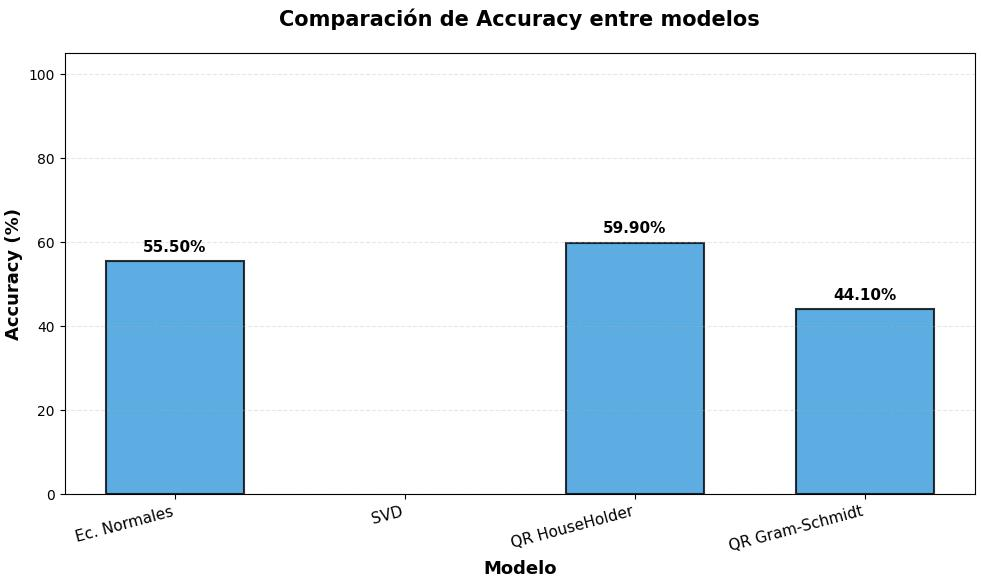

# Ejercicio 7 

Si bien la metrica de *Accuracy* es una buena forma de ver su performance a groso-modo, esta bueno poder ver los casos mas especificos y para eso tenemos distintas metricas empleables, algunas de ellas son:

- ***Precision***, en donde podemos analizar cuantas de nuestras predicciones sobre perros (o gatos) fueron positivas, es importante notar que hay que evaluar la precision para perros y gatos por separado porque puede ser muy preciso para perros y bastante peor para gatos, o al revés.
- ***Recall***, en donde podemos saber cuantos de los perros (o gatos) reales pudimos identificar correctamente, esto nos dice cuantos casos verdaderos se nos están escapando. Nuevamente aca hay que diferenciar entre perros y gatos por separado para calcularlo
- ***F1-Score***, un balance entre *Precision* (no equivocarnos) y *Recall* (no olvidarnos de nadie)

Ahora bien, ademas de todo esto es fundamental tener en cuenta el coste computacional *(es claro que uno podria tener una Accuracy del 100% si clasifica las cosas a mano)*, <br>
podriamos entonces tener en cuenta el tiempo que tardaron en ejecutarse aproximadamente cada metodo para acercarnos mas a decidir cual es "el mejor", teniendo unos tiempos de ejecucion estimados en:

- Ecuaciones Normales: 1:30 horas
- QR HouseHolder: 5:30 horas
- QR Gram-Schmidt: 3 horas
- SVD: más de 12 horas (lamentablemente lo dejamos más de medio dia corriendo y no pudimos obtener los resultados)

Despues de analizar estas metricas vimos que, aunque existen diferencias entre los métodos, estas son pequeñas, la diferencia mayor esta en los tiempos y el costo computacional.
Por eso, por lo menos para este trabajo, el algoritmo de Ecuaciones Normales nos parece la mejor opción. Este es mejor que QR GS (el cual es igual o peor que un rendimiento aleatorio del 50%) y, además, consume el doble de tiempo que este último. Por otro lado, el método Householder ofrece una mejor accuracy (60%) sin embargo, solo supera en un 5% al algoritmo que tardó 3.7 veces menos en ejecutarse. La SVD completa, en cambio, nos hizo sentir como si estuviéramos programando con tarjetas perforadas, dejando el código corriendo y volviendo al día siguiente a ver si había terminado.

También, a la hora de elegir un algoritmo, es importante prestar atención a si se necesita un menor tiempo de respuesta sacrificando precisión, o si se necesita un alto grado de precisión sin importar el tiempo de ejecución. Esto debe considerarse en conjunto con el hardware o recursos que se tienen o se requieren para la ejecución.

<br>